In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
sys.path.insert(0, '/home/ym20900/ExoTiC-JEDI/')
import exotic_jedi as jedi

In [2]:
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
os.environ['CRDS_PATH'] = '/YOUR/CRDS/PATH/crds_cache/'

In [3]:
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from crds import get_default_context
print('Using crds context={}'.format(get_default_context()))

from exotic_jedi.stage_1 import CustomBiasStep, DestripingGroupsStep

Using crds context=jwst_1075.pmap


Point to files

In [4]:
# Data and version config.
data_dir = '/PATH/TO/YOUR/DATA/'

data_chunks = sorted(glob.glob(data_dir+'*nrs1_uncal.fits'))

In [5]:
data_chunk_names=[]
for file in range(len(data_chunks)):
    file_name = data_chunks[file].split('/')[-1].split('uncal.fits')[0][:-1]
    data_chunk_names.append(file_name)
print(data_chunk_names)

['jw02512010001_04102_00001-seg001_nrs1', 'jw02512010001_04102_00001-seg002_nrs1', 'jw02512010001_04102_00001-seg003_nrs1', 'jw02512010001_04102_00001-seg004_nrs1']


Point to where we want results saved

In [6]:
reduction_dir = '/your_directory/PLANET_VISIT/'
ancillary_dir = os.path.join(reduction_dir, 'ancillary')
version_dir = os.path.join(reduction_dir, 'reduction_v1')
stage_1_dir = os.path.join(version_dir, 'stage_1')
for _dir in [version_dir, stage_1_dir]:
    if not os.path.exists(_dir):
        os.mkdir(_dir)

In [7]:
# Instantiate STScI steps for NIRSpec stage 1.
stsci_group_scale = calwebb_detector1.group_scale_step.GroupScaleStep()
stsci_dq_init = calwebb_detector1.dq_init_step.DQInitStep()
stsci_saturation = calwebb_detector1.saturation_step.SaturationStep()
stsci_superbias = calwebb_detector1.superbias_step.SuperBiasStep()
stsci_refpix = calwebb_detector1.refpix_step.RefPixStep()
stsci_linearity = calwebb_detector1.linearity_step.LinearityStep()
stsci_dark_current = calwebb_detector1.dark_current_step.DarkCurrentStep()
stsci_jump = calwebb_detector1.jump_step.JumpStep()
stsci_ramp_fit = calwebb_detector1.ramp_fit_step.RampFitStep()
stsci_gain_scale = calwebb_detector1.gain_scale_step.GainScaleStep()

# Instantiate Custom steps for NIRSpec stage 1.
custom_bias = CustomBiasStep()
custom_destriping_groups = DestripingGroupsStep()

# Iterate data chunks.
for data_chunk_name in data_chunk_names:
    print()
    print()
    print('\n=======================\n')
    print('\n========= ~ ~ ~ ~ ~ ~ ~\n')
    print('\n========= Working on {} =========\n'.format(data_chunk_name))
    print('\n========= ~ ~ ~ ~ ~ ~ ~ \n')
    print('\n========================\n')
    print()
    print()

    # Read in chunk.
    raw_data_chunk = os.path.join(
        data_dir, '{}_uncal.fits'.format(data_chunk_name))
    dm_raw = datamodels.RampModel(raw_data_chunk)

    # Stage 1 reduction.
    proc = stsci_group_scale.call(dm_raw)
    proc = stsci_dq_init.call(proc)
    proc = stsci_saturation.call(proc, n_pix_grow_sat=1)
    # proc = stsci_superbias.call(proc)
    proc = custom_bias.call(proc)
    proc = stsci_refpix.call(proc, odd_even_columns=True)
    proc = stsci_linearity.call(proc)
    proc = stsci_dark_current.call(proc)
    proc = stsci_jump.call(
        proc, rejection_threshold=15., # RAMP JUMP REJECTION THRESHOLD
        flag_4_neighbors=True, min_jump_to_flag_neighbors=10.,
        three_group_rejection_threshold=15., four_group_rejection_threshold=15.,
        expand_large_events=False, skip=False)
    proc = custom_destriping_groups.call(
        proc,
        start_trace_col=606, end_trace_col=2042,
        poly_order=2, n_sigma_trace_mask=15.,
        dq_bits=[0, 1, 2, 10, 11, 13, 19],
        keep_mean_bkd_level=False,
        draw_mask=False)
    _, proc = stsci_ramp_fit.call(proc)
    stage_1_output = stsci_gain_scale.call(proc)
    stage_1_output.save(path=os.path.join(
        stage_1_dir, '{}_stage_1.fits'.format(data_chunk_name)))

2023-03-30 13:26:52,903 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-30 13:26:52,916 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-30 13:26:52,921 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-03-30 13:26:52,923 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-03-30 13:26:52,926 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2023-03-30 13:26:52,929 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-03-30 13:26:52,932 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-03-30 13:26:52,936 - stpipe.JumpStep - INFO - JumpStep instance created.
2023-03-30 13:26:52,940 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2023-03-30 13:26:52,943 - stpipe.GainScaleStep - INFO - GainScaleStep instance created.
2023-03-30 13:26:52,945 - stpipe.CustomBiasStep - INFO - CustomBiasStep instance created.
2023-03-30 13:26:52,949 - stpipe.DestripingGroup






========= ~ ~ ~ ~ ~ ~ ~


========= Working on jw02512010001_04102_00001-seg001_nrs1 =========


========= ~ ~ ~ ~ ~ ~ ~ 







2023-03-30 13:27:01,334 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0004.rmap      810 bytes  (1 / 10 files) (0 / 31.5 K bytes)
2023-03-30 13:27:01,656 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_nirspec_0320.imap    5.2 K bytes  (2 / 10 files) (810 / 31.5 K bytes)
2023-03-30 13:27:01,987 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0006.rmap    4.5 K bytes  (3 / 10 files) (6.0 K / 31.5 K bytes)
2023-03-30 13:27:02,311 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_niriss_0215.imap    5.2 K bytes  (4 / 10 files) (10.4 K / 31.5 K bytes)
2023-03-30 13:27:02,631 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_nircam_photom_0017.rmap    3.4 K bytes  (5 / 10 files) (15.6 K / 31.5 K bytes)
2023-03-30 13:27:02,957 - CRDS - INFO -  Fetching  /home/ym20900/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0004.rmap      806 by

2023-03-30 13:27:44,217 - stpipe.RefPixStep - INFO - NIR subarray data
2023-03-30 13:27:44,227 - stpipe.RefPixStep - INFO - Single readout amplifier used
2023-03-30 13:27:44,228 - stpipe.RefPixStep - INFO - The following parameter is valid for this mode:
2023-03-30 13:27:44,228 - stpipe.RefPixStep - INFO - odd_even_columns = True
2023-03-30 13:27:44,229 - stpipe.RefPixStep - INFO - The following parameters are not applicable and are ignored:
2023-03-30 13:27:44,230 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2023-03-30 13:27:44,231 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2023-03-30 13:27:44,231 - stpipe.RefPixStep - INFO - side_gain = 1.0
2023-03-30 13:27:44,232 - stpipe.RefPixStep - INFO - odd_even_rows = False
2023-03-30 13:28:18,100 - stpipe.RefPixStep - INFO - Step RefPixStep done
2023-03-30 13:28:18,117 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fa

ValidationError: Extra value 'after_jump_flag_dn1' in root

Make a quick and dirty light curve and check out the noise-y-ness

Running intrapixel extraction on 5259 spectra
No flat fielding is being performed at this time
No 1/f noise correction is being performed


100%|█████████████████████████████████████████████████████████████████████████████████| 5259/5259 [01:31<00:00, 57.24it/s]


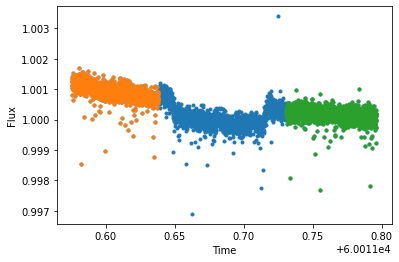

Sdev before tilt (pre transit) =  265.5605615643958  ppm
Sdev after tilt (post transit) =  226.49451888046065  ppm


In [14]:
upper_ap, lower_ap, trace_pos = np.loadtxt('NRS1_aperture.txt', unpack=True)

data_files_path = stage_1_dir #point to where the data is
rateints_files_nrs1 = glob.glob(data_files_path+'*nrs1_stage_1.fits')

ancillary_files = ancillary_dir
times = np.loadtxt(ancillary_files + 'jw02512010001_04102_0000_nrs1_all_segs_times.txt')

midtime_bjd = times[:,5]

# Get the integration time from the time file for error calculation
integration_time = np.median(abs((times[:,4]-times[:,6])*24*60*60))

trimming = 500

sci_cube, _ = jedi.unsegment(sorted(rateints_files_nrs1), 1)
sci_cube = sci_cube[:,:,trimming:-5]

all_spectra, _, _, _ = jedi.get_stellar_spectra(sci_cube, upper_ap+2, lower_ap+2, \
                                                          flat=None, f_mask=None, \
                                                          extract_method="intrapixel",  \
                                                          shift=False, plot=False, set_to_edge = True)


pre_transit = 1500 # These should be specific to your observation
pst_transit = 3700

lc = np.sum(all_spectra, axis=1)/np.sum(all_spectra[-1])

plt.figure()
plt.plot(midtime_bjd[10:], lc[10:], ls='none',marker='.')

plt.plot(midtime_bjd[10:pre_transit], lc[10:pre_transit], ls='none',marker='.')
plt.plot(midtime_bjd[pst_transit:], lc[pst_transit:], ls='none',marker='.')


plt.xlabel("Time")
plt.ylabel("Flux")

plt.show()

sdev_lcs = np.std(lc[10:pre_transit])
sdev_lce = np.std(lc[pst_transit:])

print('Sdev before tilt (pre transit) = ', sdev_lcs*1e6, ' ppm')
print('Sdev after tilt (post transit) = ', sdev_lce*1e6, ' ppm')